In [1]:
import datasets
from datasets import load_dataset
from transformers import AutoTokenizer

/project/6104653/ehghaghi/c-btm-distillation/uv-x86_64-unknown-linux-gnu/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.environ["HF_DATASETS_CACHE"] = "/home/ehghaghi/scratch/.cache/huggingface"

In [3]:
dataset = load_dataset("allenai/tulu-3-sft-mixture")

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'messages', 'source'],
        num_rows: 939343
    })
})

In [5]:
print("Total samples:", len(dataset['train']))

Total samples: 939343


In [6]:
print(dataset["train"][0])

{'id': 'oasst1_5921', 'messages': [{'content': 'Create a snippet of Terraform HCL code that create an AWS autoscaling group, and an ALB in front to expose an application to internet.', 'role': 'user'}, {'content': 'Sure, here\'s an example Terraform HCL code that creates an AWS Autoscaling Group and an Application Load Balancer to expose an application to the internet:\n``` \n# Configure the AWS provider\nprovider "aws" {\n  region = "us-east-1"\n}\n\n# Create a security group to allow traffic to the ALB\nresource "aws_security_group" "alb_sg" {\n  name_prefix = "alb_sg"\n  ingress {\n    from_port = 80\n    to_port = 80\n    protocol = "tcp"\n    cidr_blocks = ["0.0.0.0/0"]\n  }\n}\n\n# Create an ALB and target group\nresource "aws_lb" "alb" {\n  name               = "example-alb"\n  internal           = false\n  load_balancer_type = "application"\n\n  subnets = ["subnet-12345678", "subnet-87654321"]\n\n  security_groups = [aws_security_group.alb_sg.id]\n\n  tags = {\n    Environment 

In [7]:
example = dataset["train"][0]

for msg in example["messages"]:
    print(f"{msg['role']}: {msg['content']}")

user: Create a snippet of Terraform HCL code that create an AWS autoscaling group, and an ALB in front to expose an application to internet.
assistant: Sure, here's an example Terraform HCL code that creates an AWS Autoscaling Group and an Application Load Balancer to expose an application to the internet:
``` 
# Configure the AWS provider
provider "aws" {
  region = "us-east-1"
}

# Create a security group to allow traffic to the ALB
resource "aws_security_group" "alb_sg" {
  name_prefix = "alb_sg"
  ingress {
    from_port = 80
    to_port = 80
    protocol = "tcp"
    cidr_blocks = ["0.0.0.0/0"]
  }
}

# Create an ALB and target group
resource "aws_lb" "alb" {
  name               = "example-alb"
  internal           = false
  load_balancer_type = "application"

  subnets = ["subnet-12345678", "subnet-87654321"]

  security_groups = [aws_security_group.alb_sg.id]

  tags = {
    Environment = "production"
  }
}

resource "aws_lb_target_group" "target_group" {
  name        = "exampl

In [10]:
# Load Qwen tokenizer (from Hugging Face)
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-7B-Instruct", trust_remote_code=True)

In [32]:
def get_user_token_count(example):
    user_tokens = 0
    user_message_count = 0
    for msg in example["messages"]:
        if msg["role"] == "user":
            tokens = tokenizer.encode(msg["content"], add_special_tokens=False)
            user_tokens += len(tokens)
            user_message_count += 1
    return {
        "user_token_count": user_tokens,
        "user_message_count": user_message_count
    }

# Work on a subset first for speed (you can later scale)
subset = dataset['train'].shuffle(seed=1997).select(range(10000))

# Map and compute
token_stats = subset.map(get_user_token_count)

# Aggregate
total_tokens = sum(token_stats["user_token_count"])
total_messages = sum(token_stats["user_message_count"])
average_tokens = total_tokens / total_messages

max_tokens = max(token_stats["user_token_count"])
min_tokens = min(token_stats["user_token_count"])

print(f"Average tokens per user message (Qwen tokenizer): {average_tokens:.2f}")
print(f"Max tokens per user message (Qwen tokenizer): {max_tokens:.2f}")
print(f"Min tokens per user message (Qwen tokenizer): {min_tokens:.2f}")


Map: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 822.55 examples/s]


Average tokens per user message (Qwen tokenizer): 235.10
Max tokens per user message (Qwen tokenizer): 59735.00
Min tokens per user message (Qwen tokenizer): 0.00


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

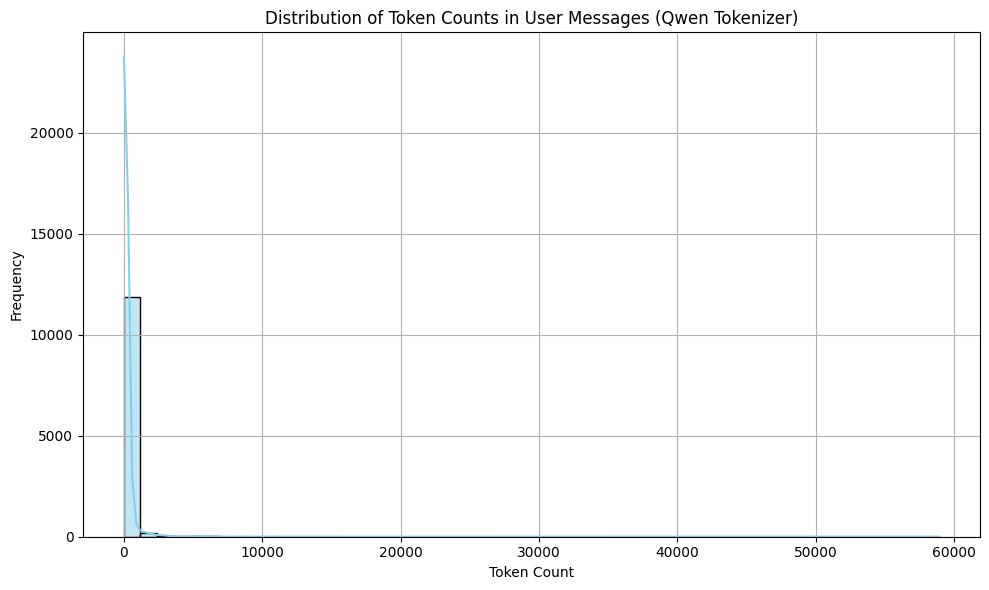

In [34]:
# Collect token counts for user messages
token_lengths = []

for example in subset:
    for msg in example["messages"]:
        if msg["role"] == "user":
            tokens = tokenizer.encode(msg["content"], add_special_tokens=False)
            token_lengths.append(len(tokens))

# Plot distribution
plt.figure(figsize=(10, 6))
sns.histplot(token_lengths, bins=50, kde=True, color="skyblue")
plt.title("Distribution of Token Counts in User Messages (Qwen Tokenizer)")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

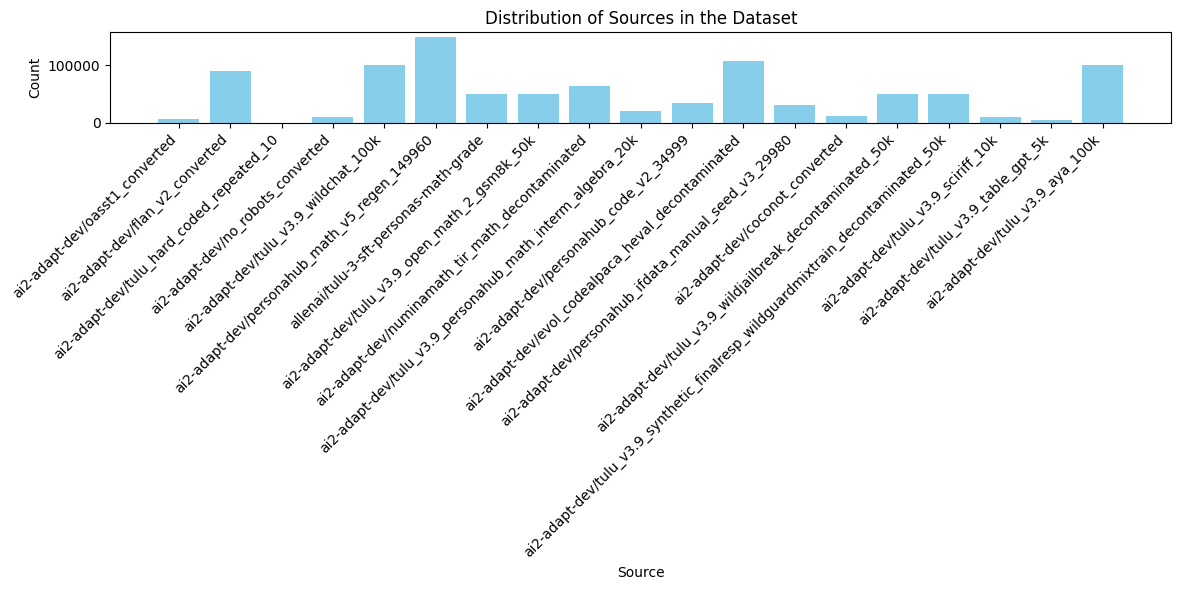

In [36]:
from collections import Counter


# Count the frequency of each source
source_counts = Counter(dataset["train"]["source"])

# Prepare data for plotting
sources = list(source_counts.keys())
counts = list(source_counts.values())

# Plot
plt.figure(figsize=(12, 6))
plt.bar(sources, counts, color="skyblue")
plt.xlabel("Source")
plt.ylabel("Count")
plt.title("Distribution of Sources in the Dataset")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


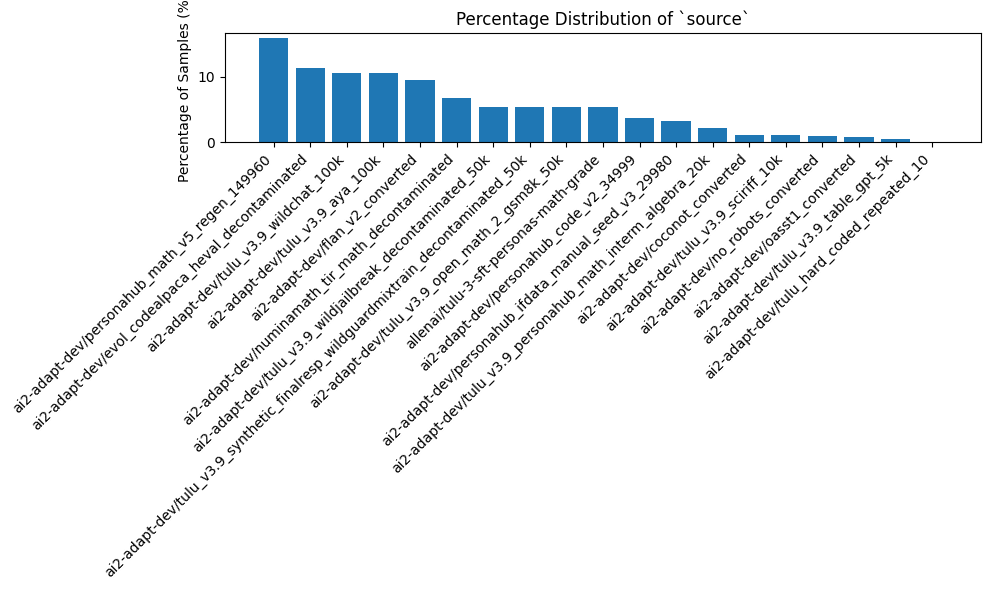

In [38]:
# 2. Count frequencies
counts = Counter(dataset["train"]["source"])
total = sum(counts.values())

# 3. Compute percentages
sources = list(counts.keys())
percentages = [100 * counts[s] / total for s in sources]

# 4. Sort by percentage (descending)
sorted_pairs = sorted(zip(percentages, sources), reverse=True)
pct_sorted, src_sorted = zip(*sorted_pairs)

# 5. Plot
plt.figure(figsize=(10, 6))
plt.bar(src_sorted, pct_sorted)
plt.ylabel("Percentage of Samples (%)")
plt.title("Percentage Distribution of `source`")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()  # Correct function name

In [39]:
import numpy as np

# Calculate average number of turns
turn_counts = [len(example["messages"]) for example in dataset["train"]]
average_turns = np.mean(turn_counts)

print(f"Average number of turns per conversation: {average_turns:.2f}")

Average number of turns per conversation: 2.37
